Decision Transformer: Reinforcement Learning via Sequence Modeling
Recreated by : Austin Runkle, Fatih Bozdogan, Haocheng Cao

In this project we will be implementing the decision transformer and comparing its preformance
to an existing RL model TD learning

# Decision Transformer for Discrete Atari (Breakout)

This section implements a **Decision Transformer (DT)** for a discrete-action Atari game (Breakout).  
The model is trained **offline** on short trajectories collected from a random policy, and then evaluated as a fixed policy.

## Tokenization scheme

For a context window of length **K**, we build **three tokens per time step**:

1. `rtg_t` — return-to-go at step *t*  
2. `s_t`  — state (stacked Atari frames) at step *t*  
3. `a_{t-1}` — previous action (a special **START** id is used at `t = 0`)

The full sequence is

\[
[\text{rtg}_0, s_0, a_{-1},
 \text{rtg}_1, s_1, a_0,
 \dots,
 \text{rtg}_{K-1}, s_{K-1}, a_{K-2}]
\]

At every **action token** position, the transformer predicts the current action `a_t`.

## Model components

- **`CNNStateEncoder`**  
  Encodes stacked Breakout frames with shape `(4, 84, 84)` into a `d_model`-dimensional vector using three convolution layers and a linear layer.

- **`CausalTransformer`**  
  A wrapper around `nn.TransformerEncoder` with a **causal mask**, so each token can only attend to previous tokens in the sequence.

- **`DecisionTransformerDiscrete`**  
  For each time step the model builds embeddings for:
  - RTG: `Linear(1 → d_model)`  
  - State: `CNNStateEncoder` → `d_model`  
  - Action: `Embedding(num_actions + 1, d_model)`  
    - The extra index is used for the START token when `a_{t-1} = -1`.  
  - Timestep: `Embedding(max_timestep, d_model)`  
  - Token type: `Embedding(3, d_model)` to distinguish `rtg / state / action`.

  These embeddings are interleaved as `[rtg, state, action] * K`, passed through the transformer, and then the hidden states at **action token positions** are projected with a linear head to logits over actions.

- **`step_mask_to_token_mask`**  
  Converts a step-level mask of shape `(B, K)` (valid vs. padded steps) into a token-level mask of shape `(B, 3K)` used by the transformer.

- **`compute_dt_loss`**  
  Takes a batch containing  
  `rtg, states, actions_in, actions_target, timesteps, step_mask`,  
  runs the DT, gathers logits at action tokens, and applies **cross-entropy loss** against `actions_target`, ignoring padded steps.

- **`compute_rtg`**  
  Computes return-to-go from a sequence of rewards, used when building offline training windows.

## Data pipeline

- **`collect_random_trajectories`**  
  Runs Breakout with a random policy to collect a small offline dataset of episodes: `(states, actions, rewards)`.

- **`DTTrajectoryDataset`**  
  - Samples a random trajectory and starting index.  
  - Creates a window of length up to **K** and pads it to length `K`:
    - `states` → `(K, 4, 84, 84)`  
    - `actions_in` (previous actions, `-1` at first valid step)  
    - `actions_target` (current actions)  
    - `rtg` from `compute_rtg`  
    - `timesteps` (absolute step index in the episode)  
    - `step_mask` (which positions are real vs. padding)  

  The `DataLoader` repeatedly draws such windows to train the DT.

## Tensor shapes (batch-first, as used in the code)

- `rtg`:             `(B, K, 1)`  
- `states`:          `(B, K, 4, 84, 84)`  
- `actions_in`:      `(B, K)` (indices for `a_{t-1}`, with `-1` = START)  
- `actions_target`:  `(B, K)` (labels for `a_t`)  
- `timesteps`:       `(B, K)`  
- `step_mask`:       `(B, K)` (True for real steps, False for padding)  
- `attention_mask`:  `(B, 3K)` (True = keep), created via `step_mask_to_token_mask`.

## Training and evaluation used in this notebook

1. **Offline training**

   - Collect random trajectories with `collect_random_trajectories`.  
   - Wrap them in `DTTrajectoryDataset` and a `DataLoader`.  
   - For each batch:
     ```python
     loss, _ = compute_dt_loss(model, batch)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
     ```
   - Log and plot the **training loss** over updates.

2. **Online evaluation: `evaluate_dt_discrete`**

   - Run Breakout using the trained DT as a fixed policy.  
   - At each step, reconstruct the last `K` tokens  
     `(rtg, states, previous actions, timesteps)`,  
     feed them into the model, and take `argmax` over the **last action token** logits.  
   - Repeat this for multiple episodes and plot the **return per episode** and/or the **average return vs. number of training updates**.

## Hyperparameters in our experiments

Typical settings in this notebook:

- `d_model = 256`, `n_layers = 4`, `n_heads = 4`, `dropout = 0.1`  
- context length `K = 20`  
- `rtg_scale` in the range `100–1000` (rescaling RTG before embedding)  
- optimizer: `AdamW(lr = 1e-4, weight_decay = 0.1)`  
- batch size around `32` (exact value depends on device memory)

These choices match the architecture and training loop used to produce the Breakout Decision Transformer figures in this notebook.


Online v. Offline RL: 
* Online: Learn from experience
* Offline RL: Learn from shown experience

[CliffWalk Q-learning] Episode 1/5000 | Return: -10009.00 | Avg over last 1 eps: -10009.00 | Steps: 1000
[CliffWalk Q-learning] Episode 1000/5000 | Return: -18.00 | Avg over last 1000 eps: -4095.23 | Steps: 18
[CliffWalk Q-learning] Episode 2000/5000 | Return: -120.00 | Avg over last 1000 eps: -169.06 | Steps: 21
[CliffWalk Q-learning] Episode 3000/5000 | Return: -13.00 | Avg over last 1000 eps: -46.26 | Steps: 13
[CliffWalk Q-learning] Episode 4000/5000 | Return: -15.00 | Avg over last 1000 eps: -30.86 | Steps: 15
[CliffWalk Q-learning] Episode 5000/5000 | Return: -17.00 | Avg over last 1000 eps: -31.78 | Steps: 17
Reached goal episodes: 4762
Fell off cliff episodes: 39398


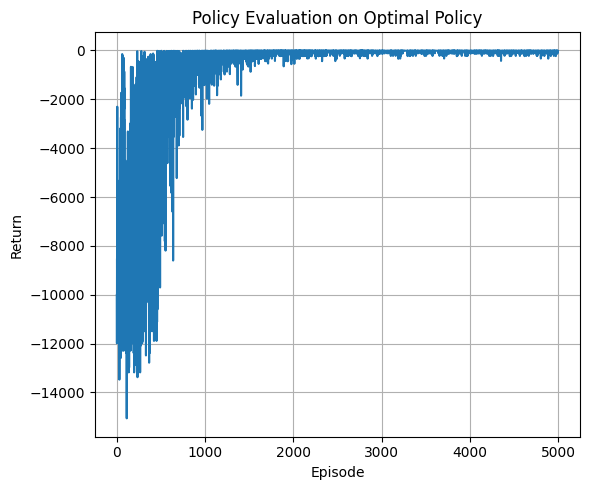

In [20]:
%run td_cliffwalk.py

Using device: mps


/Users/boldthinkingcat/UA/08 Fall 2025/CSC 496/csc496final/dt_breakout_discrete.py:209: RuntimeWarning: overflow encountered in scalar subtract
  elif paddle_x > ball_x + 2:


  Ep 1: Return 9, Length 710
  Ep 2: Return 36, Length 1310
  Ep 3: Return 48, Length 1524
  Ep 4: Return 21, Length 849
  Ep 5: Return 38, Length 1250
  Ep 6: Return 29, Length 984
  Ep 7: Return 13, Length 907
  Ep 8: Return 5, Length 499
  Ep 9: Return 11, Length 792
  Ep 10: Return 7, Length 788
  Ep 11: Return 15, Length 1406
  Ep 12: Return 11, Length 633
  Ep 13: Return 23, Length 897
  Ep 14: Return 44, Length 1672
  Ep 15: Return 21, Length 987
  Ep 16: Return 4, Length 553
  Ep 17: Return 31, Length 1180
  Ep 18: Return 26, Length 588
  Ep 19: Return 16, Length 805
  Ep 20: Return 26, Length 1314
Collected 20 trajectories. Avg Score: 21.70
Starting Training...
Step 100: Loss 0.9784
Step 200: Loss 0.9414
Step 300: Loss 0.9994
Step 400: Loss 0.8421
Step 500: Loss 0.7064
Step 600: Loss 0.6596
Step 700: Loss 0.6515
Step 800: Loss 0.5610
Step 900: Loss 0.4914
Step 1000: Loss 0.6037
Step 1100: Loss 0.4610
Step 1200: Loss 0.4006
Step 1300: Loss 0.3064
Step 1400: Loss 0.2570
Step 150

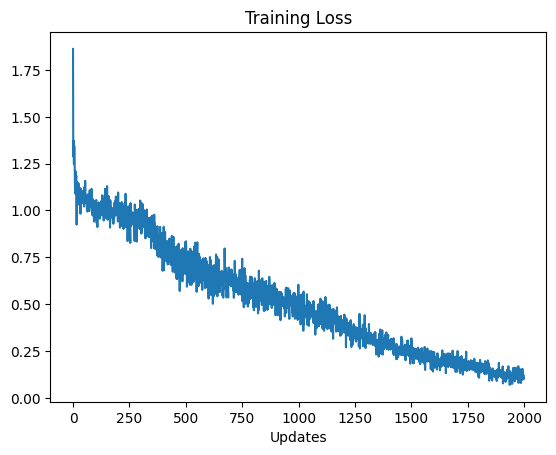

In [11]:
%run dt_breakout_discrete.py

Device: mps
Starting training...
Step 0 | Loss: 1.4397
Step 100 | Loss: 1.3397
Step 200 | Loss: 1.3109
Step 300 | Loss: 1.2447
Step 400 | Loss: 1.1258
Step 500 | Loss: 0.9751
Step 500 | Eval Return: 1.0
Step 600 | Loss: 0.5037
Step 700 | Loss: 0.3533
Step 800 | Loss: 0.2951
Step 900 | Loss: 0.2627


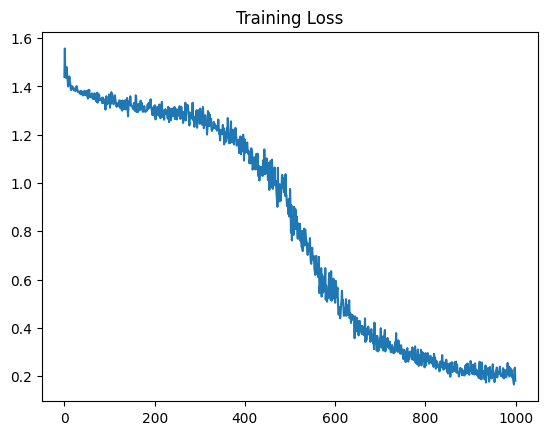

In [21]:
%run dt_breakout_dt.py

Using cpu
Generating 1000 dummy trajectories for debugging...
Training on HalfCheetah-v4 | s_dim: 17 a_dim: 6
Ep 1 | Loss: 1.2485 | Time: 1.10s
Ep 2 | Loss: 1.1633 | Time: 1.04s
Ep 3 | Loss: 1.1152 | Time: 1.00s
Ep 4 | Loss: 1.0801 | Time: 1.01s
Ep 5 | Loss: 1.0687 | Time: 1.02s
  >> Eval Score: -160.00
Ep 6 | Loss: 1.0524 | Time: 1.17s
Ep 7 | Loss: 1.0456 | Time: 1.03s
Ep 8 | Loss: 1.0439 | Time: 1.00s
Ep 9 | Loss: 1.0361 | Time: 1.00s
Ep 10 | Loss: 1.0380 | Time: 1.00s
  >> Eval Score: -71.85


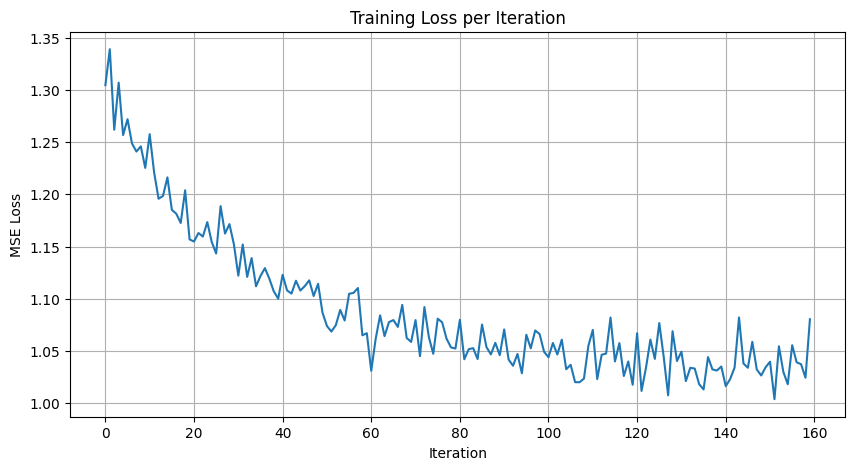

In [23]:
%run dt_halfcheetah_continuous.py

In [19]:
%run dqn_breakout_simple.py

Action Space: 4 (['NOOP', 'FIRE', 'RIGHT', 'LEFT'])
Agent running on device: cpu
Episode 1: Reward = 9.0, Steps = 576
Episode 2: Reward = 9.0, Steps = 530
Episode 3: Reward = 0.0, Steps = 201
Episode 4: Reward = 0.0, Steps = 170
Episode 5: Reward = 0.0, Steps = 372
Episode 6: Reward = 0.0, Steps = 453
Episode 7: Reward = 0.0, Steps = 264
Episode 8: Reward = 2.0, Steps = 243
Episode 9: Reward = 9.0, Steps = 632
Episode 10: Reward = 9.0, Steps = 534
Episode 11: Reward = 9.0, Steps = 537
Episode 12: Reward = 0.0, Steps = 236
Episode 13: Reward = 0.0, Steps = 238
Episode 14: Reward = 0.0, Steps = 223
Episode 15: Reward = 0.0, Steps = 271
Episode 16: Reward = 0.0, Steps = 228
Episode 17: Reward = 0.0, Steps = 320
Episode 18: Reward = 0.0, Steps = 245
Episode 19: Reward = 5.0, Steps = 751
Episode 20: Reward = 0.0, Steps = 316


## Notes on the Figures

Here is a short summary of each figure we generated. I’m writing them in a way that you can drop directly into the report or notebook.

---

### Figure 1 – Q-learning on CliffWalk

- **What it is**  
  Tabular **Q-learning** on the 4×12 CliffWalk gridworld. The curve shows **episode return vs. episode index** over 5000 training episodes.

- **What the curve shows**  
  - At the beginning, returns are extremely low (large negative values) because the agent keeps falling into the cliff.  
  - Over time the return climbs towards about **–13**, which is near-optimal: the agent reaches the goal with minimal steps and rarely falls off the cliff.

- **Weaknesses / possible improvements**  
  - Convergence is relatively slow: it takes hundreds of episodes before the curve stabilizes.  
  - Pure ε-greedy and fixed learning rate are simple; more advanced exploration or learning-rate schedules could shorten the transient phase.

- **Relation to our topic**  
  This serves as a **baseline TD control method**. It shows how a classic temporal-difference method learns from online interaction, which we later compare against the sequence-modeling approach of Decision Transformers.

---

### Figure 2 – Decision Transformer on Breakout (single run, 50 episodes)

- **What it is**  
  A **Decision Transformer (DT)** trained offline on random Breakout trajectories, then evaluated as a fixed policy. The plot shows **return per episode over 50 evaluation episodes**.

- **What the curve shows**  
  - Most returns fall between **1 and 3 points**, so the learned policy can occasionally score a few bricks but is far from expert level.  
  - The performance is very noisy: some episodes score 3, others drop back to 1.

- **Weaknesses / possible improvements**  
  - The offline dataset is small and generated by a random policy, so the DT has limited high-quality behaviour to imitate.  
  - More diverse and higher-return demonstrations, longer training, or slightly larger context length K would likely improve stability and maximum score.

- **Relation to our topic**  
  This figure shows that even with **offline random data**, a Decision Transformer can learn a weak but non-trivial Breakout policy. It illustrates DT as a **sequence-modeling alternative** to traditional RL on Atari.

---

### Figures 3a & 3b – DT Training Curves on Breakout

**Figure 3a – Training loss vs. updates**

- **What it is**  
  Cross-entropy **training loss** of the Breakout DT plotted against the number of parameter updates.

- **What the curve shows**  
  - Loss starts around ~1.4 and decreases smoothly toward ~0.2.  
  - This indicates the model is getting better at predicting the next action given (rtg, state, previous action).

- **Weaknesses / possible improvements**  
  - Loss never goes to zero, which is expected because the data are noisy and come from a random policy.  
  - However, the tail of the curve is still gently sloping; more training or a slightly larger model might squeeze out small extra gains.

**Figure 3b – Average eval return vs. training updates**

- **What it is**  
  For every 100 updates, we run several evaluation episodes and plot the **average return** vs. the number of training updates.

- **What the curve shows**  
  - The eval return generally improves as training progresses (with noise), reaching around **2–2.5 points** at the best checkpoints.  
  - This ties the loss curve to actual control performance: lower loss roughly corresponds to better game scores.

- **Weaknesses / possible improvements**  
  - The curve is jagged, reflecting high variance from a small number of evaluation episodes and a weak policy.  
  - Using more eval episodes or a better offline dataset could produce a smoother, higher curve.

- **Relation to our topic**  
  Together, these two plots demonstrate **how the DT optimizes its sequence-prediction objective and how that translates into returns** on Breakout, which is central to understanding Decision Transformers as return-conditioned sequence models.

---

### Figure 4 – Decision Transformer on HalfCheetah (continuous control)

- **What it is**  
  A **continuous-action Decision Transformer** applied to the MuJoCo **HalfCheetah-v4** environment. We train the model on synthetic data and plot **MSE training loss vs. gradient step**.

- **What the curve shows**  
  - The loss drops quickly at the start, then settles around ~1.0 with small fluctuations.  
  - This indicates the model can fit the (state, action) relationships in the dataset reasonably well.

- **Weaknesses / possible improvements**  
  - The experiment uses randomly generated data rather than a real expert dataset, so low loss doesn’t necessarily mean good control behaviour.  
  - Replacing the synthetic data with trajectories from a strong HalfCheetah policy would make the experiment more realistic and the learned policy more meaningful.

- **Relation to our topic**  
  This figure illustrates that the same **Decision Transformer architecture extends naturally from discrete Atari actions to continuous MuJoCo actions**, supporting our overall theme that DT is a general sequence-modeling framework for RL across very different environments.


### How our notebook relates to the original Decision Transformer results

We do **not** attempt to reproduce the full D4RL benchmarks from the Decision Transformer paper.  
Instead, our notebook is a **scaled-down, educational version** designed to illustrate the key ideas:

- On **CliffWalk**, we show how classical TD control (tabular Q-learning) learns an optimal policy online.
- On **Breakout**, we train a **Decision Transformer** from a small offline dataset of random trajectories and show that it can still achieve non-trivial scores, even without any online interaction.
- On **HalfCheetah**, we demonstrate that the same Decision Transformer architecture naturally extends to **continuous-action control**, and we visualize the training loss.

These results qualitatively support the main intuition of the Decision Transformer paper — that RL can be cast as return-conditioned sequence modeling — but they are **not a quantitative reproduction** of Table 2, where DT is compared to strong offline RL baselines on large D4RL datasets.
